In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.aqua.utils.arithmetic import normalize_vector
from qiskit.visualization import plot_histogram
from scipy.optimize import fmin_cobyla
import numpy as np

In [68]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
state_simulator = Aer.get_backend('statevector_simulator')
unitary_simulator = Aer.get_backend('unitary_simulator')
backend = Aer.get_backend('qasm_simulator')

In [69]:
def Task2(params=[0,0]):
    qc = QuantumCircuit(qr, cr)
    qc.rx(params[0],0)
    qc.rx(params[1],1)
    qc.cx(0,1)
    qc.ry(params[2],0)
    qc.ry(params[3],1)
    qc.measure([0,1],[0,1])
    return qc

In [72]:
desired_vector = [0,1,0,1]
desired_vector = normalize_vector(desired_vector)
print(desired_vector)


[0.         0.70710678 0.         0.70710678]


In [73]:
qc_target = QuantumCircuit(qr, cr)
# qc_target.initialize(desired_vector, [0,1])
# implement bell state |w> that get the state as 1/sqrt(2)(|01>+|10>)
qc_target.x(1)
qc_target.h(0)
qc_target.cx(0,1)
qc_target.measure([0,1],[0,1])
qc_target.barrier()
qc_target.draw()

┌───┐     ┌─┐    ░ 
q1_0: ┤ H ├──■──┤M├────░─
      ├───┤┌─┴─┐└╥┘┌─┐ ░ 
q1_1: ┤ X ├┤ X ├─╫─┤M├─░─
      └───┘└───┘ ║ └╥┘ ░ 
c1_0: ═══════════╩══╬════
                    ║    
c1_1: ══════════════╩════

In [74]:
def loss_fn(target,result):
    return np.array(list(({k: (result[k] - target[k])**2 for k in target}.values())))

In [82]:
target_prob = {'00': 0, '01': 0.70710678, '10': 0.70710678, '11': 0}

In [83]:
bounds=[ [0,2*np.pi] for _  in range(4)]
cons_min=[]
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = lambda x, lb=lower, i=factor: x[i] - lb
    u = lambda x, ub=upper, i=factor: ub - x[i]
    cons_min.append(l)
    cons_min.append(u)

In [84]:
history = []
Nfeval = 1
shots = 1000
def f(x):
    circ = Task2(x)
    job = execute(circ, backend, shots=shots)
    result = job.result().get_counts()
    result_prop = {'00':0,'01':0,'10':0,'11':0}
    for key, value in result.items():
        if key in result_prop.keys():
            result_prop[key]=value/shots
    loss = sum(loss_fn(target_prob,result_prop))/4.0
    global Nfeval,history
    history.append(loss)
    print('{0:4d}   {1: 3.6f} '.format(Nfeval, loss))
    Nfeval += 1
    return loss

In [85]:
params = np.zeros(shape=(4,))
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
res = fmin_cobyla(f,rand_params,cons=cons_min)

Iter   f(X)     
   1    0.500000 
   2    0.407768 
   3    0.282337 
   4    0.351145 
   5    0.210008 
   6    0.123486 
   7    0.193785 
   8    0.168164 
   9    0.108947 
  10    0.080840 
  11    0.116411 
  12    0.082856 
  13    0.091506 
  14    0.100495 
  15    0.111662 
  16    0.095030 
  17    0.079268 
  18    0.062150 
  19    0.048521 
  20    0.046497 
  21    0.061652 
  22    0.041038 
  23    0.030761 
  24    0.025943 
  25    0.025759 
  26    0.028696 
  27    0.030853 
  28    0.026524 
  29    0.029794 
  30    0.024592 
  31    0.024180 
  32    0.022976 
  33    0.023891 
  34    0.025990 
  35    0.024094 
  36    0.025171 
  37    0.023417 
  38    0.024476 
  39    0.023852 
  40    0.025335 
  41    0.023287 
  42    0.023532 
  43    0.025174 
  44    0.023786 
  45    0.023006 
  46    0.025246 
  47    0.024001 
  48    0.025347 
  49    0.023303
  50    0.023618 
  51    0.025613 
  52    0.023270 
  53    0.024146 
  54    0.023491 
  55    0.02

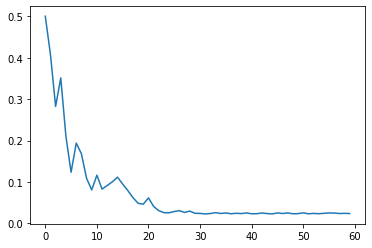

In [86]:
plt.plot(history)

In [87]:
circ = Task2(res)
job = execute(circ, backend, shots=shots)
result = job.result().get_counts()
print(result)

{'00': 13, '10': 550, '11': 8, '01': 429}


In [88]:
circ.draw()

┌────────────┐     ┌─────────────┐┌─┐   
q1_0: ┤ RX(1.4833) ├──■──┤ RY(0.20374) ├┤M├───
      ├────────────┤┌─┴─┐├─────────────┤└╥┘┌─┐
q1_1: ┤ RX(3.1594) ├┤ X ├┤ RY(0.18106) ├─╫─┤M├
      └────────────┘└───┘└─────────────┘ ║ └╥┘
c1_0: ═══════════════════════════════════╩══╬═
                                            ║ 
c1_1: ══════════════════════════════════════╩═